## Install & Import Libraries

In [ ]:
# install library
!pip3 install rasterio
!pip3 install pyspatialml --no-deps

In [ ]:
# import libraries
import pandas as pd # for data frame
import numpy as np # for calculation
import seaborn as sns # for visualization
import matplotlib.pyplot as plt # for visualization
import rasterio as rio # for raster data
import joblib

# algorithms to use
from sklearn.ensemble import RandomForestRegressor

# to split data for train and test model
from sklearn.model_selection import train_test_split

# metrics to evaluate the model
from sklearn import metrics # mae, rmse, r2

# for tuning the model
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# for apply model to raster
from pyspatialml import Raster

# to plot raster data
from rasterio.plot import show, show_hist

# to ignore warnings
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

## Load data

In [ ]:
# load extracted sample data
GEDI = pd.read_excel('/content/drive/MyDrive/Skripsi/Final/GEDI20_final.xlsx')
Field = pd.read_excel('/content/drive/MyDrive/Skripsi/Final/Field20_final_ed.xlsx')

In [ ]:
# shuffle data
GEDI_shuffled = GEDI.sample(frac=1, random_state = 42)
Field_shuffled = Field.sample(frac=1, random_state = 42)

## Determine X, y (predictors, response)

In [ ]:
# GEDI data
X_GEDI = GEDI_shuffled[['senb2', 'senb3', 'senb4', 'senb5', 'senb6', 'senb7', 'senb8a', 'senb11', 'senb12',
                   'EVI', 'NDVI', 'RVI', 'SAVI',
                   'HH_db', 'HV_db', 'HH_HV', 'HV_HH','RFDI', 'RVI_hh'
                   ]]
y_GEDI = GEDI_shuffled['agcd']

# field data
X_Field = Field_shuffled[['senb2', 'senb3', 'senb4', 'senb5', 'senb6', 'senb7', 'senb8a', 'senb11', 'senb12',
                   'EVI', 'NDVI', 'RVI', 'SAVI',
                   'HH_db', 'HV_db', 'HH_HV', 'HV_HH','RFDI', 'RVI_hh']]
y_Field = Field_shuffled['agcd']

## Split Training-Testing Data

In [ ]:
'''
# split GEDI data
XG_train, XG_test, yG_train, yG_test = train_test_split(X_GEDI, y_GEDI, test_size = 0.3, random_state = 42)

# split field data
XF_train, XF_test, yF_train, yF_test = train_test_split(X_Field, y_Field, test_size = 0.4, random_state = 42)

In [ ]:
'''
# # export splited data to drive
# join y & X
GEDI_train = pd.concat([yG_train, XG_train], axis=1, join='inner')
GEDI_test = pd.concat([yG_test, XG_test], axis=1, join='inner')
Field_train = pd.concat([yF_train, XF_train], axis=1, join='inner')
Field_test = pd.concat([yF_test, XF_test], axis=1, join='inner')

# export data
with pd.ExcelWriter('/content/drive/MyDrive/Skripsi/Final/Export5/Sample_splited_5.xlsx') as writer:
    GEDI_train.to_excel(writer, sheet_name='GEDI_train')
    GEDI_test.to_excel(writer, sheet_name='GEDI_test')
    Field_train.to_excel(writer, sheet_name='Field_train')
    Field_test.to_excel(writer, sheet_name='Field_test')

In [ ]:

## load exported splited data

# read excel file
xls_sample = pd.ExcelFile('/content/drive/MyDrive/Skripsi/Final/Export/Sample_splited_1.xlsx')

# read sheet
GEDI_train = pd.read_excel(xls_sample, 'GEDI_train')
GEDI_test = pd.read_excel(xls_sample, 'GEDI_test')
Field_train = pd.read_excel(xls_sample, 'Field_train')
Field_test = pd.read_excel(xls_sample, 'Field_test')

# split X, y
XG_train = GEDI_train[['senb2', 'senb3', 'senb4', 'senb5', 'senb6', 'senb7', 'senb8a', 'senb11', 'senb12',
                   'EVI', 'NDVI', 'RVI', 'SAVI',
                   'HH_db', 'HV_db', 'HH_HV', 'HV_HH','RFDI', 'RVI_hh']]
XG_test =  GEDI_test[['senb2', 'senb3', 'senb4', 'senb5', 'senb6', 'senb7', 'senb8a', 'senb11', 'senb12',
                   'EVI', 'NDVI', 'RVI', 'SAVI',
                   'HH_db', 'HV_db', 'HH_HV', 'HV_HH','RFDI', 'RVI_hh']]
yG_train = GEDI_train[['agcd']]
yG_test = GEDI_test[['agcd']]

XF_train = Field_train[['senb2', 'senb3', 'senb4', 'senb5', 'senb6', 'senb7', 'senb8a', 'senb11', 'senb12',
                   'EVI', 'NDVI', 'RVI', 'SAVI',
                   'HH_db', 'HV_db', 'HH_HV', 'HV_HH','RFDI', 'RVI_hh']]
XF_test =  Field_test[['senb2', 'senb3', 'senb4', 'senb5', 'senb6', 'senb7', 'senb8a', 'senb11', 'senb12',
                   'EVI', 'NDVI', 'RVI', 'SAVI',
                   'HH_db', 'HV_db', 'HH_HV', 'HV_HH','RFDI', 'RVI_hh']]
yF_train = Field_train[['agcd']]
yF_test = Field_test[['agcd']]

# Convert y data from DataFrames to Series
yG_train = yG_train.squeeze()
yG_test = yG_test.squeeze()
yF_train = yF_train.squeeze()
yF_test = yF_test.squeeze()

## Build Model & Tune Hyperparameter (RandomForest)

In [ ]:
# create parameter grid to be tuned
rf_param_grid = {
    'n_estimators' : [100, 300, 500],
    'max_features' : np.arange(1, 20, 3), # [1],
    'criterion' : ['absolute_error'],
    'max_depth' : np.arange(1, 10, 2), #[7],
    'bootstrap' : [True],
    'oob_score' : [True]
    }

# define random forest
rf = RandomForestRegressor()

In [ ]:
# tune parameter with grid GridSearch (for GEDI data)
GS_GEDI = GridSearchCV(estimator = rf, param_grid = rf_param_grid,
                            cv = 10, n_jobs = -1, verbose = 1,
                            scoring= ['r2', 'neg_root_mean_squared_error', 'neg_mean_absolute_error'],
                            refit = 'neg_root_mean_squared_error')

# tune parameter with GridSearch (for GEDI field)
GS_Field = GridSearchCV(estimator = rf, param_grid = rf_param_grid,
                            cv = 5, n_jobs = -1, verbose = 1,
                            scoring= ['r2', 'neg_root_mean_squared_error', 'neg_mean_absolute_error'],
                            refit = 'neg_root_mean_squared_error')

In [ ]:
# fit data to grid search (GEDI)
GS_GEDI.fit(XG_train, yG_train)

Fitting 10 folds for each of 105 candidates, totalling 1050 fits


GridSearchCV(cv=10, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'bootstrap': [True], 'criterion': ['absolute_error'],
                         'max_depth': array([1, 3, 5, 7, 9]),
                         'max_features': array([ 1,  4,  7, 10, 13, 16, 19]),
                         'n_estimators': [100, 300, 500], 'oob_score': [True]},
             refit='neg_root_mean_squared_error',
             scoring=['r2', 'neg_root_mean_squared_error',
                      'neg_mean_absolute_error'],
             verbose=1)

In [ ]:
# fit data to grid search (Field)
GS_Field.fit(XF_train, yF_train)

Fitting 5 folds for each of 105 candidates, totalling 525 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'bootstrap': [True], 'criterion': ['absolute_error'],
                         'max_depth': array([1, 3, 5, 7, 9]),
                         'max_features': array([ 1,  4,  7, 10, 13, 16, 19]),
                         'n_estimators': [100, 300, 500], 'oob_score': [True]},
             refit='neg_root_mean_squared_error',
             scoring=['r2', 'neg_root_mean_squared_error',
                      'neg_mean_absolute_error'],
             verbose=1)

In [ ]:
# print best model
print('========= BEST MODEL (GEDI) =========')
print("Best estimator     : ", GS_GEDI.best_estimator_)
print("Best parameter     : ", GS_GEDI.best_params_)
print("Best score (MAE)   : ", GS_GEDI.best_score_)
print("Best index         : ", GS_GEDI.best_index_)

print('========= BEST MODEL (Field) =========')
print("Best estimator     : ", GS_Field.best_estimator_)
print("Best parameter     : ", GS_Field.best_params_)
print("Best score (MAE)   : ", GS_Field.best_score_)
print("Best index         : ", GS_Field.best_index_)

========= BEST MODEL (GEDI) =========
Best estimator     :  RandomForestRegressor(criterion='absolute_error', max_depth=7, max_features=1,
                      n_estimators=300, oob_score=True)
Best parameter     :  {'bootstrap': True, 'criterion': 'absolute_error', 'max_depth': 7, 'max_features': 1, 'n_estimators': 300, 'oob_score': True}
Best score (MAE)   :  -34.87463648426977
Best index         :  64
========= BEST MODEL (Field) =========
Best estimator     :  RandomForestRegressor(criterion='absolute_error', max_depth=5, max_features=1,
                      oob_score=True)
Best parameter     :  {'bootstrap': True, 'criterion': 'absolute_error', 'max_depth': 5, 'max_features': 1, 'n_estimators': 100, 'oob_score': True}
Best score (MAE)   :  -29.56883324513715
Best index         :  42


In [ ]:
# # export GridSearch result to drive
# convert result to dataframe
GS_GEDI_df = pd.DataFrame(GS_GEDI.cv_results_)
GS_Field_df = pd.DataFrame(GS_Field.cv_results_)

'''
# export dataframe
with pd.ExcelWriter('/content/drive/MyDrive/Skripsi/Final/Export5/GridSearch_result_5.xlsx') as writer:
    GS_GEDI_df.to_excel(writer, sheet_name='GEDI')
    GS_Field_df.to_excel(writer, sheet_name='Field')
'''

"\n# export dataframe\nwith pd.ExcelWriter('/content/drive/MyDrive/Skripsi/Final/Export5/GridSearch_result_5.xlsx') as writer:\n    GS_GEDI_df.to_excel(writer, sheet_name='GEDI')\n    GS_Field_df.to_excel(writer, sheet_name='Field')\n"

In [ ]:
# select RandomForest best model from GridSearch
rf_GEDI_best = GS_GEDI.best_estimator_
rf_Field_best = GS_Field.best_estimator_

In [ ]:

# # export Random Forest best model to drive
# export model (so, it can be used again)
joblib.dump(rf_GEDI_best, '/content/drive/MyDrive/Skripsi/Final/Export5/rf_gedi_5.sav')
joblib.dump(rf_Field_best, '/content/drive/MyDrive/Skripsi/Final/Export5/rf_field_5.sav')

# export cv
joblib.dump(GS_GEDI, '/content/drive/MyDrive/Skripsi/Final/Export5/GS_gedi_5.sav')
joblib.dump(GS_Field, '/content/drive/MyDrive/Skripsi/Final/Export5/GS_field_5.sav')


In [ ]:
# load the exported model (in case you want to use it again)
rf_GEDI_best = joblib.load('/content/drive/MyDrive/Skripsi/Final/Export5/rf_gedi_5.sav')
rf_Field_best = joblib.load('/content/drive/MyDrive/Skripsi/Final/Export5/rf_field_5.sav')

# Load the grid search object from the file
GS_GEDI = joblib.load('/content/drive/MyDrive/Skripsi/Final/Export5/GS_gedi_5.sav')
GS_Field = joblib.load('/content/drive/MyDrive/Skripsi/Final/Export5/GS_field_5.sav')

In [ ]:
# # predict with RandomForest best model
# with model trained by GEDI data
ypred_train_GEDI = rf_GEDI_best.predict(XG_train)
ypred_test_GEDI = rf_GEDI_best.predict(XG_test)
ypred_field_GEDI = rf_GEDI_best.predict(XF_test)

# with model trained by Field data
ypred_train_Field = rf_Field_best.predict(XF_train)
ypred_test_Field = rf_Field_best.predict(XF_test)

In [ ]:
# obtain the OOB error
oob_GEDI = 1 - rf_GEDI_best.oob_score_
oob_Field = 1 - rf_Field_best.oob_score_

# print the OOB error
print(f'OOB error (GEDI)  : {oob_GEDI:.3f}')
print(f'OOB error (Field) : {oob_Field:.3f}')

OOB error (GEDI)  : 0.907
OOB error (Field) : 1.031


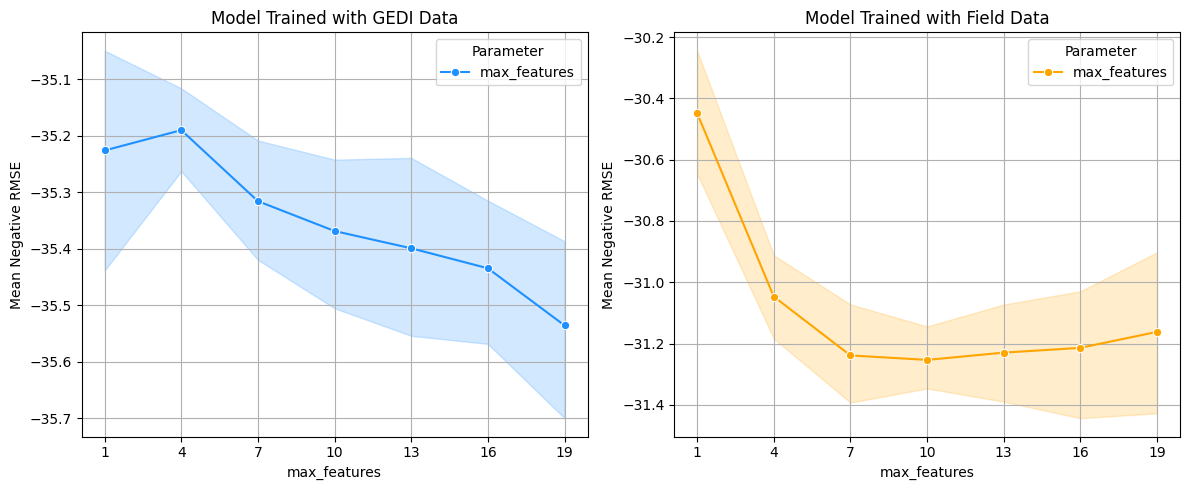

In [ ]:
# Ensure the 'param_max_features' is an integer for both DataFrames
GS_GEDI_df['param_max_features'] = GS_GEDI_df['param_max_features'].astype(int)
GS_Field_df['param_max_features'] = GS_Field_df['param_max_features'].astype(int)

# Create a figure with 2 subplots side-by-side
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot for GS_GEDI_df
sns.lineplot(
    data=GS_GEDI_df,
    x='param_max_features',
    y='mean_test_neg_root_mean_squared_error',
    marker='o',
    label='max_features',
    color='dodgerblue',
    ax=axes[0]
)
axes[0].set_title('Model Trained with GEDI Data')
axes[0].set_xlabel('max_features')
axes[0].set_ylabel('Mean Negative RMSE')
axes[0].legend(title='Parameter')
axes[0].grid(True)
axes[0].set_xticks(GS_GEDI_df['param_max_features'].unique())

# Plot for GS_Field_df
sns.lineplot(
    data=GS_Field_df,
    x='param_max_features',
    y='mean_test_neg_root_mean_squared_error',
    marker='o',
    label='max_features',
    color='orange',
    ax=axes[1]
)
axes[1].set_title('Model Trained with Field Data')
axes[1].set_xlabel('max_features')
axes[1].set_ylabel('Mean Negative RMSE')
axes[1].legend(title='Parameter')
axes[1].grid(True)
axes[1].set_xticks(GS_Field_df['param_max_features'].unique())

# Adjust layout and save the plot
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Skripsi/Final/Export5/RMSE_maxfeature_all.png')
plt.show()


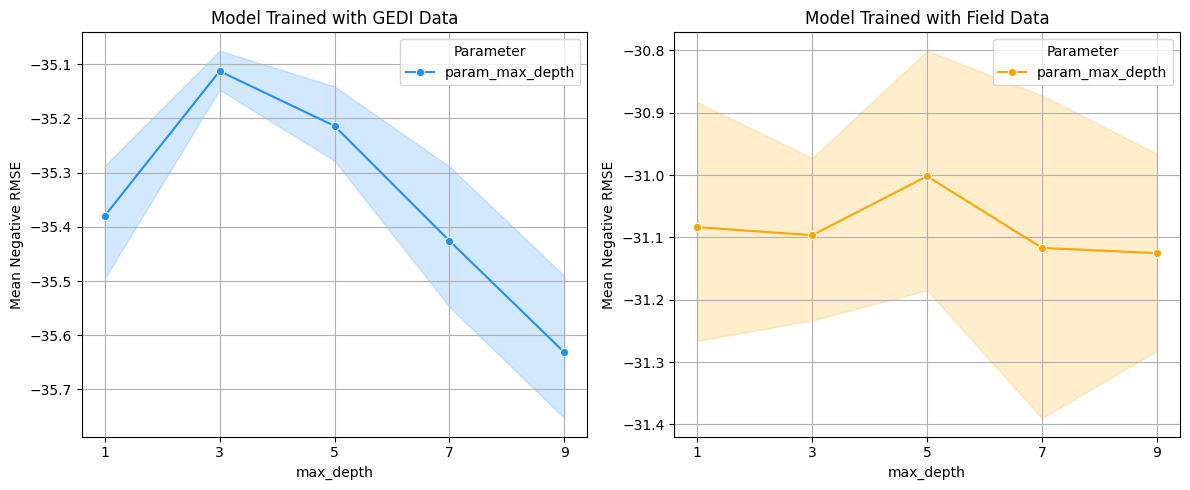

In [ ]:
# Ensure the 'param_max_depth' is an integer for both DataFrames
GS_GEDI_df['param_max_depth'] = GS_GEDI_df['param_max_depth'].astype(int)
GS_Field_df['param_max_depth'] = GS_Field_df['param_max_depth'].astype(int)

# Create a figure with 2 subplots side-by-side
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot for GS_GEDI_df
sns.lineplot(
    data=GS_GEDI_df,
    x='param_max_depth',
    y='mean_test_neg_root_mean_squared_error',
    marker='o',
    label='param_max_depth',
    color='dodgerblue',
    ax=axes[0]
)
axes[0].set_title('Model Trained with GEDI Data')
axes[0].set_xlabel('max_depth')
axes[0].set_ylabel('Mean Negative RMSE')
axes[0].legend(title='Parameter')
axes[0].grid(True)
axes[0].set_xticks(GS_GEDI_df['param_max_depth'].unique())

# Plot for GS_Field_df
sns.lineplot(
    data=GS_Field_df,
    x='param_max_depth',
    y='mean_test_neg_root_mean_squared_error',
    marker='o',
    label='param_max_depth',
    color='orange',
    ax=axes[1]
)
axes[1].set_title('Model Trained with Field Data')
axes[1].set_xlabel('max_depth')
axes[1].set_ylabel('Mean Negative RMSE')
axes[1].legend(title='Parameter')
axes[1].grid(True)
axes[1].set_xticks(GS_Field_df['param_max_depth'].unique())

# Adjust layout and save the plot
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Skripsi/Final/Export5/RMSE_maxdepth_all.png')
plt.show()


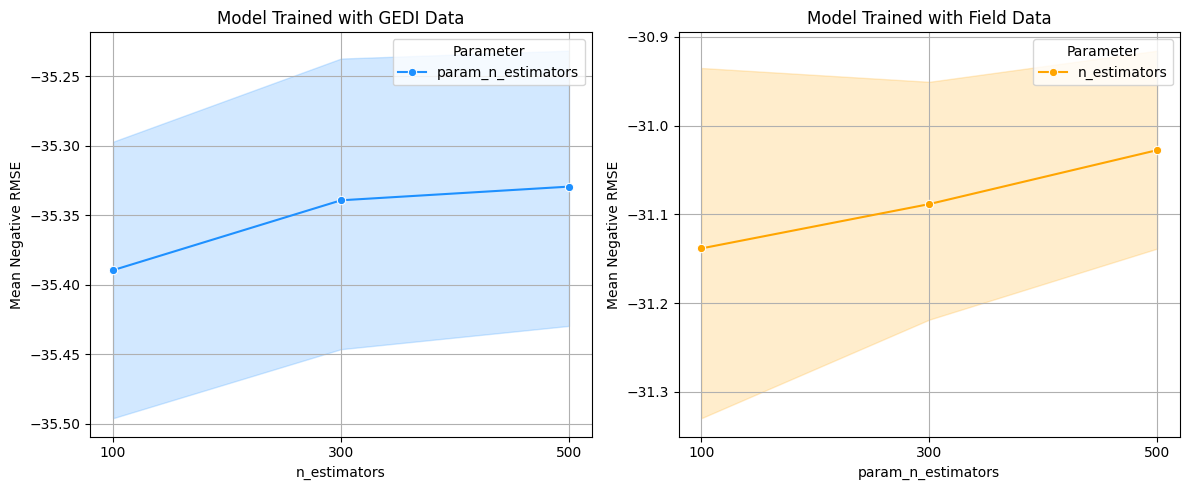

In [ ]:
# Ensure the 'param_max_depth' is an integer for both DataFrames
GS_GEDI_df['param_n_estimators'] = GS_GEDI_df['param_n_estimators'].astype(int)
GS_Field_df['param_n_estimators'] = GS_Field_df['param_n_estimators'].astype(int)

# Create a figure with 2 subplots side-by-side
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot for GS_GEDI_df
sns.lineplot(
    data=GS_GEDI_df,
    x='param_n_estimators',
    y='mean_test_neg_root_mean_squared_error',
    marker='o',
    label='param_n_estimators',
    color='dodgerblue',
    ax=axes[0]
)
axes[0].set_title('Model Trained with GEDI Data')
axes[0].set_xlabel('n_estimators')
axes[0].set_ylabel('Mean Negative RMSE')
axes[0].legend(title='Parameter')
axes[0].grid(True)
axes[0].set_xticks(GS_GEDI_df['param_n_estimators'].unique())

# Plot for GS_Field_df
sns.lineplot(
    data=GS_Field_df,
    x='param_n_estimators',
    y='mean_test_neg_root_mean_squared_error',
    marker='o',
    label='n_estimators',
    color='orange',
    ax=axes[1]
)
axes[1].set_title('Model Trained with Field Data')
axes[1].set_xlabel('param_n_estimators')
axes[1].set_ylabel('Mean Negative RMSE')
axes[1].legend(title='Parameter')
axes[1].grid(True)
axes[1].set_xticks(GS_Field_df['param_n_estimators'].unique())

# Adjust layout and save the plot
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Skripsi/Final/Export5/RMSE_nestimators_all.png')
plt.show()


## Model Evaluation

### Evaluation for Model Trained by GEDI Data

In [ ]:
print('============= ### MODEL EVALUATION (GEDI DATA) ### =============')

print('====== TRAINING ACCURACY ======')
print('MAE        : ', metrics.mean_absolute_error(yG_train, ypred_train_GEDI))
print('RMSE       : ', np.sqrt(metrics.mean_squared_error(yG_train, ypred_train_GEDI)))
print('R-Squared  : ', metrics.r2_score(yG_train, ypred_train_GEDI))

print('====== TESTING ACCURACY ======')
print('MAE        : ', metrics.mean_absolute_error(yG_test, ypred_test_GEDI))
print('RMSE       : ', np.sqrt(metrics.mean_squared_error(yG_test, ypred_test_GEDI)))
print('R-Squared  : ', metrics.r2_score(yG_test, ypred_test_GEDI))
def r2G_oos_test(y_test, y_pred, y_train):
    y_bar = y_train.mean()
    ss_tot = ((y_bar - y_test)**2).sum()
    ss_res = ((y_pred - y_test)**2).sum()
    return 1 - (ss_res / ss_tot)
print('OOS R-squared  : ', r2G_oos_test(yG_test, ypred_test_GEDI, yG_train))

print('====== FIELD TESTING ACCURACY ======')
print('MAE            : ', metrics.mean_absolute_error(yF_test, ypred_field_GEDI))
print('RMSE           : ', np.sqrt(metrics.mean_squared_error(yF_test, ypred_field_GEDI)))
print('R-Squared      : ', metrics.r2_score(yF_test, ypred_field_GEDI))
def r2G_oos_field(y_field, y_pred, y_train):
    y_bar = y_train.mean()
    ss_tot = ((y_bar - y_field)**2).sum()
    ss_res = ((y_pred - y_field)**2).sum()
    return 1 - (ss_res / ss_tot)
print('OOS R-squared  : ', r2G_oos_field(yF_test, ypred_field_GEDI, yG_train))

============= ### MODEL EVALUATION (GEDI DATA) ### =============
====== TRAINING ACCURACY ======
MAE        :  19.319903100437198
RMSE       :  26.953449589144427
R-Squared  :  0.48593880492218633
====== TESTING ACCURACY ======
MAE        :  23.47840049441227
RMSE       :  28.971466158957103
R-Squared  :  0.10010542355776653
OOS R-squared  :  0.10019220310944055
====== FIELD TESTING ACCURACY ======
MAE            :  22.316566615230407
RMSE           :  26.298273254645895
R-Squared      :  0.10071987199379373
OOS R-squared  :  0.3382909686048925


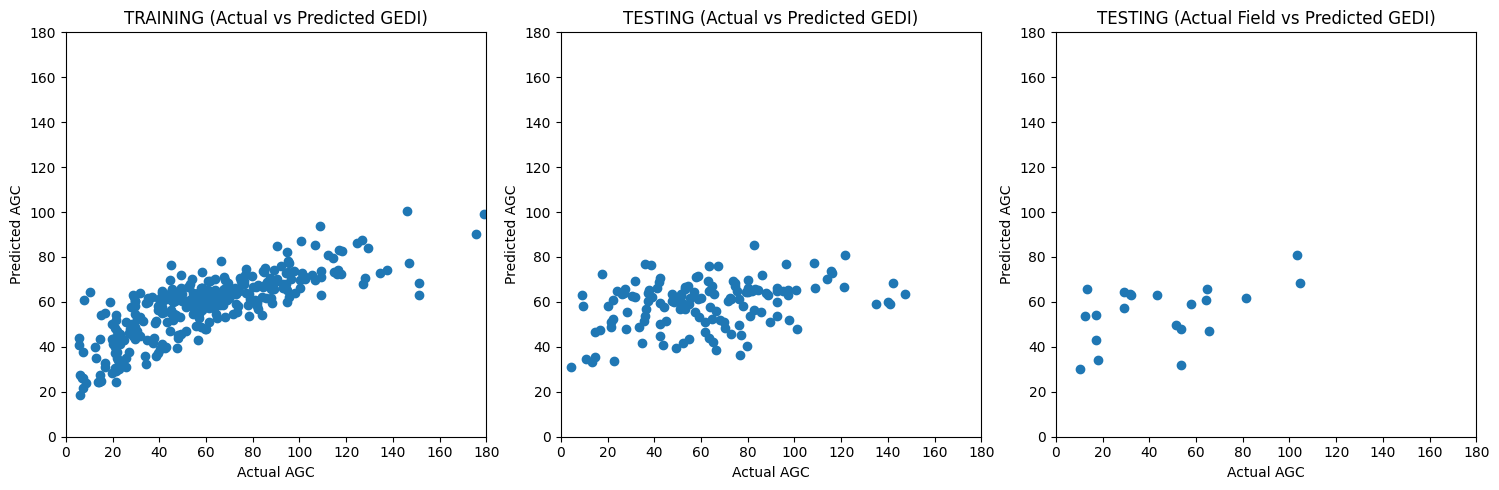

In [ ]:
# # Create scatter plot 'actual' vs 'predicted' for model trained by GEDI data
# Create subplots with 1 row and 3 columns
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Scatter plot for training data
axes[0].scatter(yG_train, ypred_train_GEDI)
axes[0].set_title('TRAINING (Actual vs Predicted GEDI)')
axes[0].set_xlabel('Actual AGC')
axes[0].set_ylabel('Predicted AGC')
axes[0].set_xlim(0, 180)
axes[0].set_ylim(0, 180)

# Scatter plot for testing data
axes[1].scatter(yG_test, ypred_test_GEDI)
axes[1].set_title('TESTING (Actual vs Predicted GEDI)')
axes[1].set_xlabel('Actual AGC')
axes[1].set_ylabel('Predicted AGC')
axes[1].set_xlim(0, 180)
axes[1].set_ylim(0, 180)

# Scatter plot for field data
axes[2].scatter(yF_test, ypred_field_GEDI)
axes[2].set_title('TESTING (Actual Field vs Predicted GEDI)')
axes[2].set_xlabel('Actual AGC')
axes[2].set_ylabel('Predicted AGC')
axes[2].set_xlim(0, 180)
axes[2].set_ylim(0, 180)

plt.tight_layout()
plt.show()

### Evaluation for Model Trained by Field Data

In [ ]:
print('============= ### MODEL EVALUATION (FIELD DATA) ### =============')

print('====== TRAINING ACCURACY ======')
print('MAE        : ', metrics.mean_absolute_error(yF_train, ypred_train_Field))
print('RMSE       : ', np.sqrt(metrics.mean_squared_error(yF_train, ypred_train_Field)))
print('R-Squared  : ', metrics.r2_score(yF_train, ypred_train_Field))

print('====== TESTING ACCURACY ======')
print('MAE        : ', metrics.mean_absolute_error(yF_test, ypred_test_Field))
print('RMSE       : ', np.sqrt(metrics.mean_squared_error(yF_test, ypred_test_Field)))
print('R-Squared  : ', metrics.r2_score(yF_test, ypred_test_Field))
def r2F_oos_test(y_test, y_pred, y_train):
    y_bar = y_train.mean()
    ss_tot = ((y_bar - y_test)**2).sum()
    ss_res = ((y_pred - y_test)**2).sum()
    return 1 - (ss_res / ss_tot)
print('OOS R-squared  : ', r2F_oos_test(yF_test, ypred_test_Field, yG_train))

============= ### MODEL EVALUATION (FIELD DATA) ### =============
====== TRAINING ACCURACY ======
MAE        :  9.061346673100006
RMSE       :  13.648756003142731
R-Squared  :  0.8213668313871498
====== TESTING ACCURACY ======
MAE        :  21.24695722694286
RMSE       :  24.733617033363103
R-Squared  :  0.20454467507715202
OOS R-squared  :  0.4146874192141099


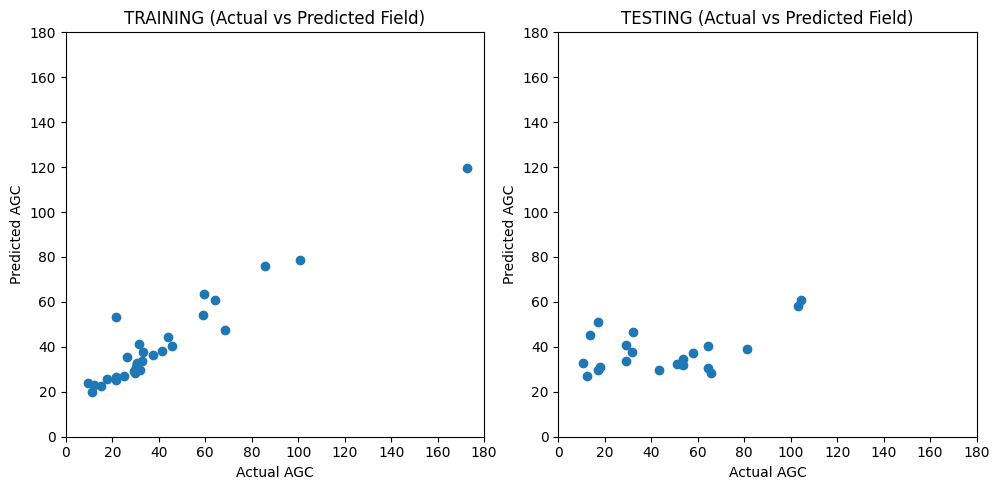

In [ ]:
# # Create scatter plot 'actual' vs 'predicted' for model trained by GEDI data
# Create subplots with 1 row and 3 columns
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Scatter plot for training data
axes[0].scatter(yF_train, ypred_train_Field)
axes[0].set_title('TRAINING (Actual vs Predicted Field)')
axes[0].set_xlabel('Actual AGC')
axes[0].set_ylabel('Predicted AGC')
axes[0].set_xlim(0, 180)
axes[0].set_ylim(0, 180)

# Scatter plot for testing data
axes[1].scatter(yF_test, ypred_test_Field)
axes[1].set_title('TESTING (Actual vs Predicted Field)')
axes[1].set_xlabel('Actual AGC')
axes[1].set_ylabel('Predicted AGC')
axes[1].set_xlim(0, 180)
axes[1].set_ylim(0, 180)

plt.tight_layout()
plt.show()

### Plot 1:1

In [ ]:
# TRAIN GEDI
# compare actual output values with predicted value
result_train_GEDI = pd.DataFrame({'Actual': yG_train, 'Predicted': ypred_train_GEDI})
result_train_GEDI_shorted = result_train_GEDI.sort_values(by='Actual')
# Display the sorted DataFrame
print(result_train_GEDI_shorted)

         Actual   Predicted
75     5.725416   40.895792
104    5.856601   43.795924
175    6.194436   18.462634
122    6.250531   27.299851
284    6.785293   26.318017
..          ...         ...
63   191.235266  113.541280
133  193.191802   79.916472
182  196.574000   84.294386
51   230.129932  122.393993
238  231.443947   98.738293

[319 rows x 2 columns]


In [ ]:
# TRAIN FIELD
# compare actual output values with predicted value
result_train_Field = pd.DataFrame({'Actual': yF_train, 'Predicted': ypred_train_Field})
result_train_Field_shorted = result_train_Field.sort_values(by='Actual')
# Display the sorted DataFrame
print(result_train_Field_shorted)

        Actual   Predicted
0     9.681880   21.418226
19   11.464481   23.228979
9    12.302058   25.139903
29   15.347674   22.455489
2    17.820863   27.183756
11   21.473401   37.274218
18   21.612876   27.480566
14   21.645656   28.342775
10   24.895383   26.476202
28   26.423526   34.825060
6    29.229391   31.444751
13   29.627042   29.010285
12   30.152980   37.794282
22   30.666841   28.347748
21   30.736994   28.850096
15   31.434164   38.711577
3    32.081456   30.754192
25   32.810591   34.335525
8    33.140209   39.497553
24   37.468555   34.034196
16   41.230773   37.093704
26   43.874647   42.750410
5    45.589452   37.620782
1    59.026276   44.889309
7    59.635644   62.449142
20   64.093843   60.250215
23   68.476910   42.287302
4    85.698764   73.729304
27  100.810958   80.616688
17  172.677242  118.972352


In [ ]:
# TEST GEDI
# compare actual output values with predicted value
result_test_GEDI = pd.DataFrame({'Actual': yG_test, 'Predicted': ypred_test_GEDI})
result_test_GEDI_shorted = result_test_GEDI.sort_values(by='Actual')
# Display the sorted DataFrame
print(result_test_GEDI_shorted)

         Actual  Predicted
34     4.447825  30.915171
72     9.258282  63.223832
74     9.597750  58.217001
99    10.653651  34.438680
87    13.557486  33.288652
..          ...        ...
116  135.075630  59.277740
103  139.964646  59.828552
42   140.932544  59.154315
1    142.331399  68.303973
57   147.382594  63.690909

[138 rows x 2 columns]


In [ ]:
# TEST FIELD
# compare actual output values with predicted value
result_test_field = pd.DataFrame({'Actual': yF_test, 'Predicted_Field': ypred_test_Field, 'Predicted_GEDI': ypred_field_GEDI})
result_test_field_shorted = result_test_field.sort_values(by='Actual')
# Display the sorted DataFrame
print(result_test_field_shorted)

        Actual  Predicted_Field  Predicted_GEDI
16   10.574514        26.170513       29.979584
3    12.365104        25.776078       53.711229
5    13.565399        43.670384       65.647050
17   17.279178        30.338122       53.982418
12   17.285518        41.284939       42.847761
6    17.935806        27.417841       34.068057
13   29.026201        32.388072       57.467219
0    29.076958        38.130252       64.430718
18   31.736376        37.426328       63.532340
10   32.309847        39.790491       63.267042
11   43.280285        33.759068       63.098169
9    51.263191        33.825403       49.842742
4    53.688510        29.811903       32.037249
19   53.735381        35.330465       48.025289
7    58.015959        36.994322       59.077445
20   64.462336        39.831965       60.736730
15   64.620689        28.019451       65.567933
2    65.684089        29.654016       47.020483
8    81.333437        42.774364       61.711710
14  103.283529        52.763091       81

In [ ]:
# Export result to Excel
with pd.ExcelWriter('/content/drive/MyDrive/Skripsi/Final/Export5/Actual_Predicted_5.xlsx') as writer:
    result_test_field_shorted.to_excel(writer, sheet_name='test_Field')
    result_test_GEDI_shorted.to_excel(writer, sheet_name='test_GEDI')
    result_train_Field_shorted.to_excel(writer, sheet_name='train_Field')
    result_train_GEDI_shorted.to_excel(writer, sheet_name='train_GEDI')

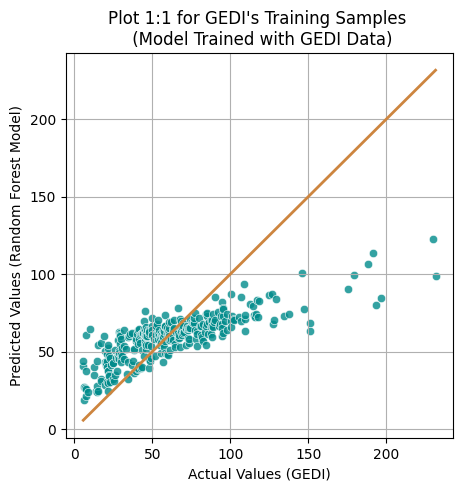

In [ ]:
# Create the 1:1 plot (Train GEDI)
plt.figure(figsize=(5, 5))
sns.scatterplot(x='Actual', y='Predicted', data=result_train_GEDI_shorted, color='darkcyan', alpha=0.8)
plt.plot([result_train_GEDI_shorted['Actual'].min(), result_train_GEDI_shorted['Actual'].max()],
         [result_train_GEDI_shorted['Actual'].min(), result_train_GEDI_shorted['Actual'].max()],
         color='peru', linewidth=2)  # 1:1 line
plt.xlabel('Actual Values (GEDI)')
plt.ylabel('Predicted Values (Random Forest Model)')
plt.title('Plot 1:1 for GEDI\'s Training Samples \n (Model Trained with GEDI Data)')
plt.grid(True)
plt.savefig('/content/drive/MyDrive/Skripsi/Final/Export5/Plot_GEDI_Train.png')
plt.show()


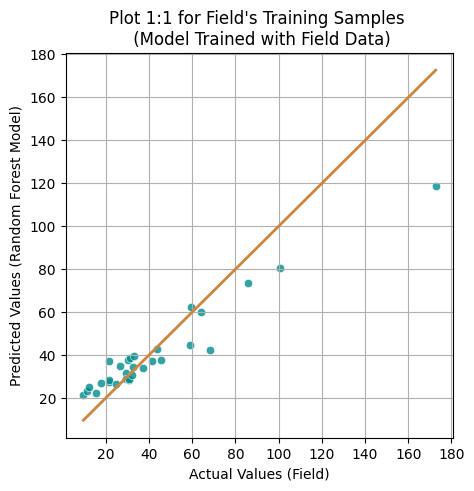

In [ ]:
# Create the 1:1 plot (Train Field)
plt.figure(figsize=(5, 5))
sns.scatterplot(x='Actual', y='Predicted', data=result_train_Field_shorted, color='darkcyan', alpha=0.8)
plt.plot([result_train_Field_shorted['Actual'].min(), result_train_Field_shorted['Actual'].max()],
         [result_train_Field_shorted['Actual'].min(), result_train_Field_shorted['Actual'].max()],
         color='peru', linewidth=2)  # 1:1 line
plt.xlabel('Actual Values (Field)')
plt.ylabel('Predicted Values (Random Forest Model)')
plt.title('Plot 1:1 for Field\'s Training Samples \n (Model Trained with Field Data)')
plt.grid(True)
plt.savefig('/content/drive/MyDrive/Skripsi/Final/Export5/Plot_Field_Train.png')
plt.show()

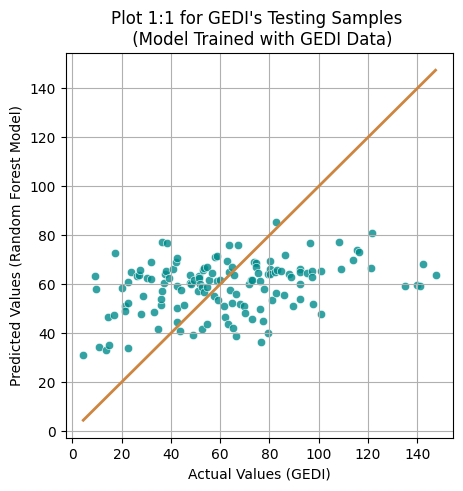

In [ ]:
# Create the 1:1 plot (Test GEDI)
plt.figure(figsize=(5, 5))
sns.scatterplot(x='Actual', y='Predicted', data=result_test_GEDI_shorted, color='darkcyan', alpha=0.8)
plt.plot([result_test_GEDI_shorted['Actual'].min(), result_test_GEDI_shorted['Actual'].max()],
         [result_test_GEDI_shorted['Actual'].min(), result_test_GEDI_shorted['Actual'].max()],
         color='peru', linewidth=2)  # 1:1 line
plt.xlabel('Actual Values (GEDI)')
plt.ylabel('Predicted Values (Random Forest Model)')
plt.title('Plot 1:1 for GEDI\'s Testing Samples \n (Model Trained with GEDI Data)')
plt.grid(True)
plt.savefig('/content/drive/MyDrive/Skripsi/Final/Export5/Plot_GEDI_Test1.png')
plt.show()


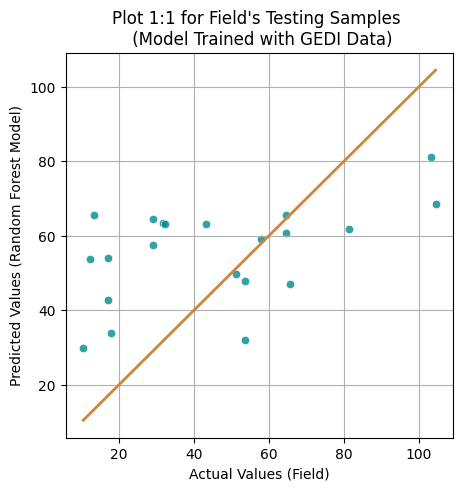

In [ ]:
# Create the 1:1 plot (Test Field)
plt.figure(figsize=(5, 5))
sns.scatterplot(x='Actual', y='Predicted_GEDI', data=result_test_field_shorted, color='darkcyan', alpha=0.8)
plt.plot([result_test_field_shorted['Actual'].min(), result_test_field_shorted['Actual'].max()],
         [result_test_field_shorted['Actual'].min(), result_test_field_shorted['Actual'].max()],
         color='peru', linewidth=2)  # 1:1 line
plt.xlabel('Actual Values (Field)')
plt.ylabel('Predicted Values (Random Forest Model)')
plt.title('Plot 1:1 for Field\'s Testing Samples \n (Model Trained with GEDI Data)')
plt.grid(True)
plt.savefig('/content/drive/MyDrive/Skripsi/Final/Export5/Plot_GEDI_Test2.png')
plt.show()


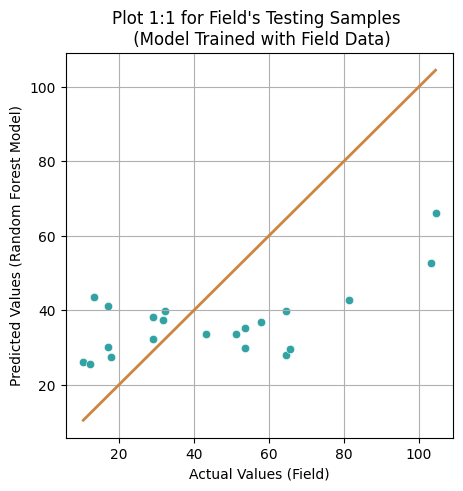

In [ ]:
# Create the 1:1 plot (Test Field)
plt.figure(figsize=(5, 5))
sns.scatterplot(x='Actual', y='Predicted_Field', data=result_test_field_shorted, color='darkcyan', alpha=0.8)
plt.plot([result_test_field_shorted['Actual'].min(), result_test_field_shorted['Actual'].max()],
         [result_test_field_shorted['Actual'].min(), result_test_field_shorted['Actual'].max()],
         color='peru', linewidth=2)  # 1:1 line
plt.xlabel('Actual Values (Field)')
plt.ylabel('Predicted Values (Random Forest Model)')
plt.title('Plot 1:1 for Field\'s Testing Samples \n (Model Trained with Field Data)')
plt.grid(True)
plt.savefig('/content/drive/MyDrive/Skripsi/Final/Export5/Plot_Field_Test.png')
plt.show()


### Variable Importance

In [ ]:
# get features list
X_GEDI_rename = X_GEDI.rename(columns={'senb2':'Sen2_B2',
                                       'senb3':'Sen2_B3',
                                       'senb4':'Sen2_B4',
                                       'senb5':'Sen2_B5',
                                       'senb6':'Sen2_B6',
                                       'senb7':'Sen2_B7',
                                       'senb8a':'Sen2_B8A',
                                       'senb11':'Sen2_B11',
                                       'senb12':'Sen2_B12',
                                       'HH_db': 'HH',
                                       'HV_db': 'HV',
                                       'HH_HV': 'HH/HV',
                                       'HV_HH': 'HV/HH',
                                       'RVI_hh' : 'RVI (HH)',
                                       })
fs = X_GEDI_rename.columns

# get the variables importances
imp_GEDI = list(rf_GEDI_best.feature_importances_)
imp_Field = list(rf_Field_best.feature_importances_)

# Sort characteristics and importances based on importances values
sorted_idx_GEDI = np.argsort(imp_GEDI)[::1]
sorted_fs_GEDI = [fs[i] for i in sorted_idx_GEDI]
sorted_imp_GEDI = [imp_GEDI[i] for i in sorted_idx_GEDI]

sorted_idx_Field = np.argsort(imp_Field)[::1]
sorted_fs_Field = [fs[i] for i in sorted_idx_Field]
sorted_imp_Field = [imp_Field[i] for i in sorted_idx_Field]

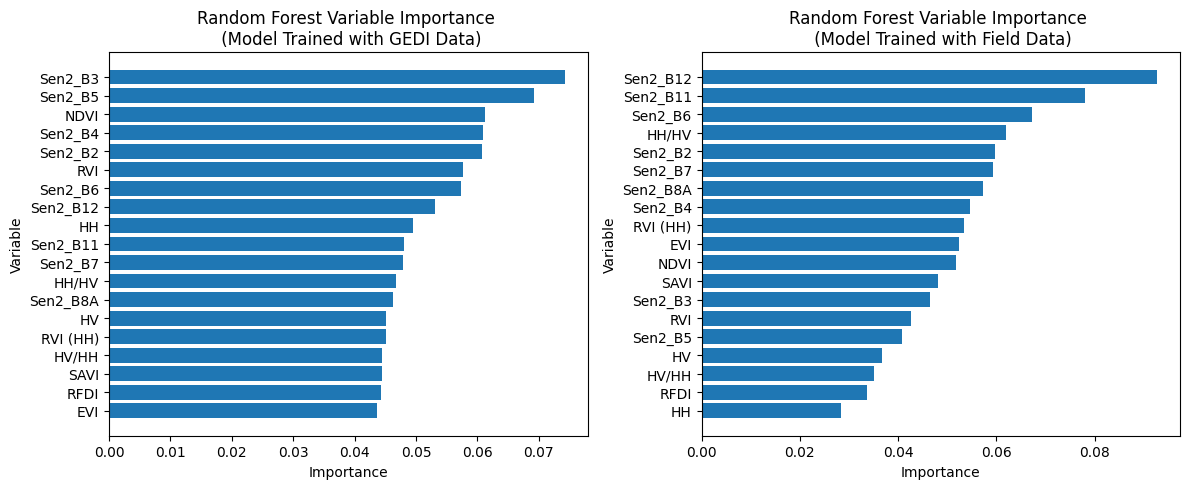

In [ ]:
# # # plot variable importance
# Create subplots with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot for GEDI feature importances
axes[0].barh(sorted_fs_GEDI, sorted_imp_GEDI)
axes[0].set_title('Random Forest Variable Importance \n (Model Trained with GEDI Data)')
axes[0].set_xlabel('Importance')
axes[0].set_ylabel('Variable')

# Plot for Field feature importances
axes[1].barh(sorted_fs_Field, sorted_imp_Field)
axes[1].set_title('Random Forest Variable Importance \n (Model Trained with Field Data)')
axes[1].set_xlabel('Importance')
axes[1].set_ylabel('Variable')

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Skripsi/Final/Export5/VarImp_RF5.png')
plt.show()

In [ ]:
# # Export variable important value to drive (excel)
# Create DataFrame for GEDI feature importances
df_GEDI_importances = pd.DataFrame({'Feature': sorted_fs_GEDI, 'Importance': sorted_imp_GEDI})
df_Field_importances = pd.DataFrame({'Feature': sorted_fs_Field, 'Importance': sorted_imp_Field})

# export
with pd.ExcelWriter('/content/drive/MyDrive/Skripsi/Final/Export5/Variable_Imp5.xlsx') as writer:
    df_GEDI_importances.to_excel(writer, sheet_name='GEDI')
    df_Field_importances.to_excel(writer, sheet_name='Field')

## Apply Model to Raster

In [ ]:
# load raster data
input = "/content/drive/MyDrive/Skripsi/Final/predictor20_clip.tif"
predictors_raster = [input]

# stack raster
stack = Raster(predictors_raster)
stack

Raster Object Containing 19 Layers
    attribute                                             values
0       names  [b2, b3, b4, b5, b6, b7, b8a, b11, b12, HH_db,...
1       files  [/content/drive/MyDrive/Skripsi/Final/predicto...
2        rows                                                563
3        cols                                                516
4         res                                       (20.0, 20.0)
5  nodatavals  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...


In [ ]:
# check raster layer's name
print(stack.names)

dict_keys(['b2', 'b3', 'b4', 'b5', 'b6', 'b7', 'b8a', 'b11', 'b12', 'HH_db', 'HV_db', 'EVI', 'NDVI', 'RVI', 'SAVI', 'HH_HV', 'HV_HH', 'RFDI', 'RVI_hh'])


In [ ]:
# rename raster layer (same as dataframe)
stack.rename({"b2":'senb2',
              "b3":'senb3',
              "b4":'senb4',
              "b5":'senb5',
              "b6":'senb6',
              "b7":'senb7',
              "b8a":'senb8a',
              "b11":'senb11',
              "b12":'senb12',
              "EVI":"EVI",
              "NDVI":"NDVI",
              "RVI":"RVI",
              "SAVI":"SAVI",
              "HH_db":'HH_db',
              "HV_db":'HV_db',
              "HH_HV":'HH_HV',
              "HV_HH":'HV_HH',
              "RFDI":'RFDI',
              "RVI_hh":'RVI_hh',
               }, in_place=True)

# re-check raster layer's name
print(stack.names)

dict_keys(['senb2', 'senb3', 'senb4', 'senb5', 'senb6', 'senb7', 'senb8a', 'senb11', 'senb12', 'HH_db', 'HV_db', 'EVI', 'NDVI', 'RVI', 'SAVI', 'HH_HV', 'HV_HH', 'RFDI', 'RVI_hh'])


In [ ]:
# predict raster pixel value with RandomForest model (GEDI)
result_GEDI = stack.predict(estimator=rf_GEDI_best, dtype = 'float64', nodata =-1)
result_Field = stack.predict(estimator=rf_Field_best, dtype = 'float64', nodata =-1)

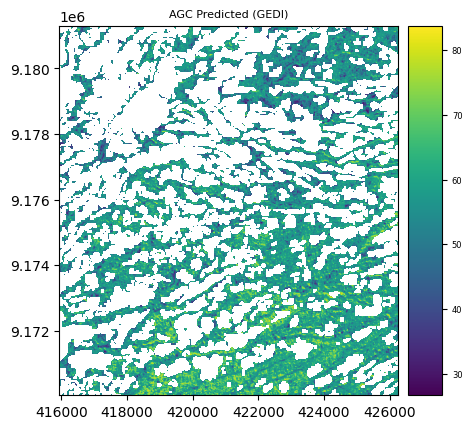

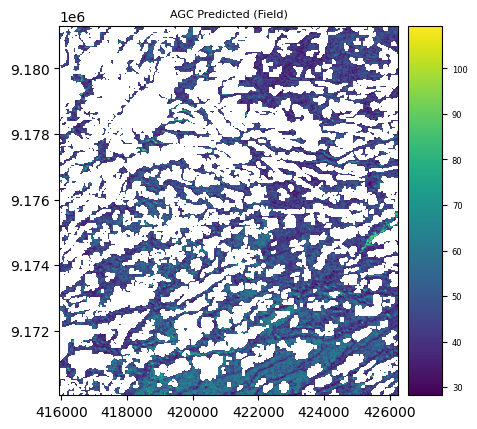

In [ ]:
# plot the result
result_GEDI.names = ['AGC Predicted (GEDI)']
result_GEDI.plot()
plt.show()

result_Field.names = ['AGC Predicted (Field)']
result_Field.plot()
plt.show()

In [ ]:
# export final result to drive
result_GEDI.write("/content/drive/MyDrive/Skripsi/Final/Export5/agc_gedi_5.tif")
result_Field.write("/content/drive/MyDrive/Skripsi/Final/Export5/agc_field_5.tif")

Raster Object Containing 1 Layers
    attribute                                             values
0       names                            [AGC Predicted (Field)]
1       files  [/content/drive/MyDrive/Skripsi/Final/Export5/...
2        rows                                                563
3        cols                                                516
4         res                                       (20.0, 20.0)
5  nodatavals                         [-1.7976931348623157e+308]
